### Here we filter (and analyse?) the geoplant dataset

We would like to then use this dataset to test the models predictions 

In [3]:
#PO Data
import pandas as pd

po_path = "embeddings_data_and_dictionaries/geoplant/PO_metadata_train.csv"

po_data= pd.read_csv(po_path)
po_data.columns


Index(['publisher', 'year', 'month', 'day', 'lat', 'lon', 'geoUncertaintyInM',
       'taxonRank', 'date', 'dayOfYear', 'speciesId', 'surveyId', 'region',
       'county', 'district'],
      dtype='object')

region
ATLANTIC         1670751
CONTINENTAL      1516041
MEDITERRANEAN     690590
ALPINE            566090
BOREAL            499637
PANNONIAN          27254
BLACK SEA           1189
ARCTIC               780
STEPPIC              465
OUTSIDE                1
Name: count, dtype: int64

### Information about the iNaturalist dataset



In [ ]:
import pandas as pd

with open("embeddings_data_and_dictionaries/data_inaturalist/occurrence.txt") as f:
    for i, line in enumerate(f, start=1):
        if i == 2:  # first data row
            print(len(line.rstrip("\n").split("\t")))
            break

occurences=pd.read_csv("embeddings_data_and_dictionaries/data_inaturalist/occurrence.txt", sep="\t", on_bad_lines='skip', nrows=0)
col_list=list(occurences.columns)
#print(col_list)
print(col_list[98])


230
['gbifID', 'accessRights', 'bibliographicCitation', 'language', 'license', 'modified', 'publisher', 'references', 'rightsHolder', 'type', 'institutionID', 'collectionID', 'datasetID', 'institutionCode', 'collectionCode', 'datasetName', 'ownerInstitutionCode', 'basisOfRecord', 'informationWithheld', 'dataGeneralizations', 'dynamicProperties', 'occurrenceID', 'catalogNumber', 'recordNumber', 'recordedBy', 'recordedByID', 'individualCount', 'organismQuantity', 'organismQuantityType', 'sex', 'lifeStage', 'reproductiveCondition', 'caste', 'behavior', 'vitality', 'establishmentMeans', 'degreeOfEstablishment', 'pathway', 'georeferenceVerificationStatus', 'occurrenceStatus', 'preparations', 'disposition', 'associatedOccurrences', 'associatedReferences', 'associatedSequences', 'associatedTaxa', 'otherCatalogNumbers', 'occurrenceRemarks', 'organismID', 'organismName', 'organismScope', 'associatedOrganisms', 'previousIdentifications', 'organismRemarks', 'materialEntityID', 'materialEntityRema

### Code for the interpretation of the sweep results

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option("display.expand_frame_repr", False)
#Get a clean run_name:
df=pd.read_csv("results/results_geoplant.csv")
df["run_name_clean"] = df["run_name"].str.replace(
    r"_(mushrooms|plants|arthropods).*",
    "",
    regex=True
)

df.to_csv("results_geoplant_clean.csv", index=False)

FileNotFoundError: [Errno 2] No such file or directory: 'results_geoplant.csv'

In [1]:
df=pd.read_csv("results_geoplant_clean.csv")

#For wich ones linear model does worse? 
small_PR = df[df["auc_emb_PR"] < df["auc_emb_MLP"]]
print(small_PR["run_name"].tolist())
print(small_PR.value_counts("model_name"))

NameError: name 'pd' is not defined

20 out of 24 classifier, 0 for contrastive.
Contrastive succeeds at "making the space linear" in that sense

In [3]:
def get_fct(colx,colf,df):
    return df.groupby(colx)[colf].mean()
def quick_plot(df,colx, colf="auc_emb_PR",kind="bar",center=True,title=None):
    if title is None:
        title=f'Mean {colf} per {colx}'
    mean_values=get_fct(colx,colf,df)
    mean_values.plot(kind=kind)  
    plt.ylabel(f'Mean {colf}')
    plt.xlabel(f'{colx}')
    plt.title(title)
    if kind=="bar" and center==True:
        ymin = mean_values.min() - 0.01
        ymax = mean_values.max() + 0.01
        plt.ylim(ymin, ymax)
    plt.show()


#highest:
def get_highest(df):
    best_row_PR = df.loc[df['auc_emb_PR'].idxmax()]
    best_row_MLP = df.loc[df['auc_emb_MLP'].idxmax()]
    print("best PR:",best_row_PR["auc_emb_PR"],best_row_PR["run_name"])
    print("best MLP:",best_row_MLP["auc_emb_PR"],best_row_PR["run_name"])
get_highest(df) #so plants
get_highest(df[df["dataset"]=="arthropods"])
get_highest(df[df["dataset"]=="mushrooms"])


test=df[df["dataset"]!="plants"]
print(test.sort_values(by="auc_emb_PR", ascending= False))



#dataset
filtered=df[df["model_name"]=="contrastive"]
filtered=filtered[filtered["drop_high_freq"]==False]
quick_plot( filtered,"dataset","auc_emb_PR","bar",title="Mean AUC per dataset (contrastive models only)")
quick_plot(df, "dataset","auc_emb_PR","bar",title="Mean AUC per dataset (all models)")


NameError: name 'df' is not defined

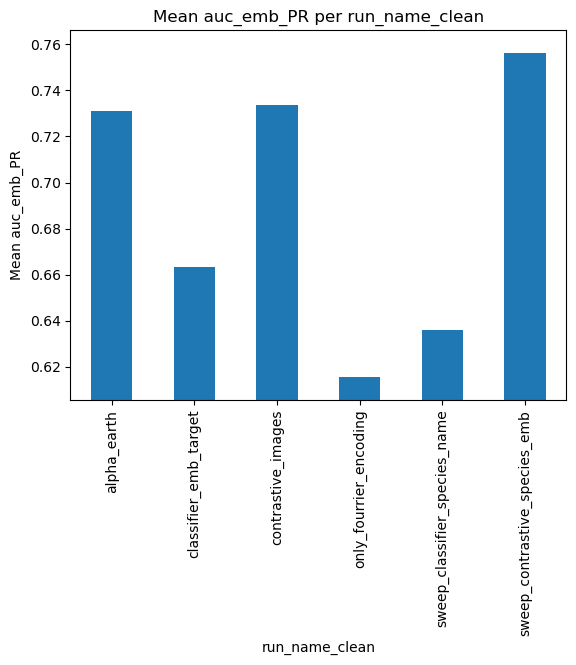

drop_high_freq
False    0.731209
True     0.751119
Name: auc_emb_PR, dtype: float64
vectors_name
vectors            0.756180
vectors_bioclip    0.742215
vectors_dino       0.725097
Name: auc_emb_PR, dtype: float64
use_species
False    0.733656
True     0.756180
Name: auc_emb_PR, dtype: float64


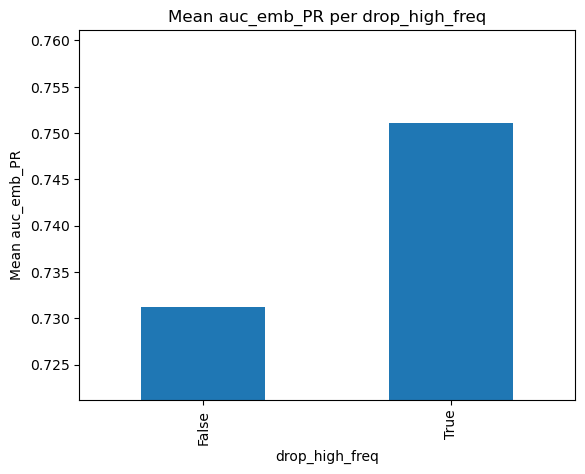

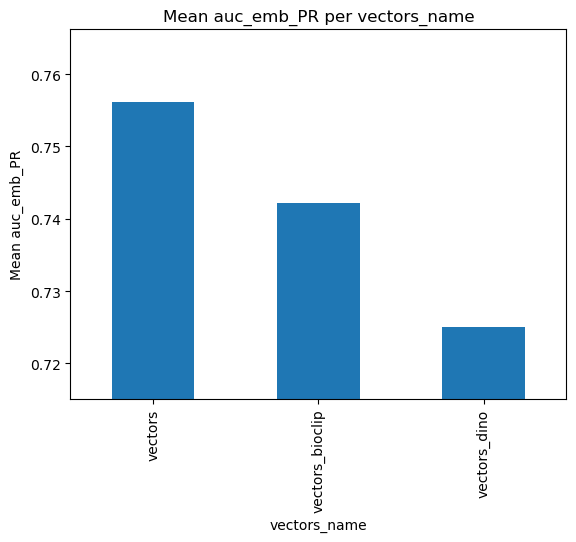

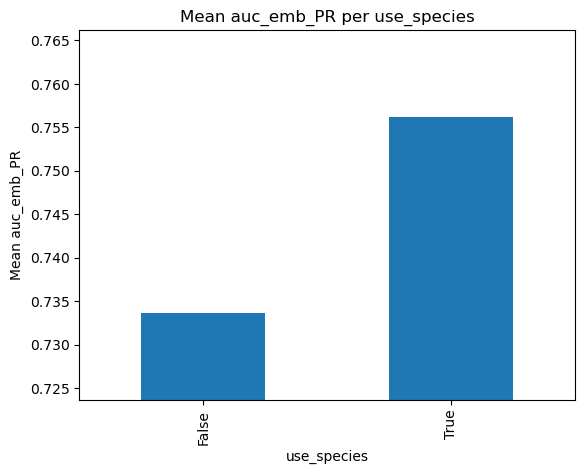

In [7]:
#Specific variable on contrastive:
quick_plot( df,"run_name_clean","auc_emb_PR","bar")


filtered=df[df["model_name"]=="contrastive"]
print(get_fct( "drop_high_freq","auc_emb_PR",filtered))
print(get_fct( "vectors_name","auc_emb_PR",filtered))
print(get_fct( "use_species","auc_emb_PR",filtered)) 

quick_plot( filtered,"drop_high_freq","auc_emb_PR","bar")
quick_plot( filtered,"vectors_name","auc_emb_PR","bar")
quick_plot( filtered,"use_species","auc_emb_PR","bar")


In [4]:

def quick_filter(df,show_alpha_earth=False, **kwargs):
    filtered_df = df

    for col, val in kwargs.items():
        if val is None:
            continue
        # Treat scalars as a list of one element
        if isinstance(val, (list, tuple, set)):
            values = val
        else:
            values = [val]
        filtered_df = filtered_df[filtered_df[col].isin(values)]
    if show_alpha_earth:
        show_alpha_earth = df.loc[df["run_name"] == "alpha_earth"]
        show_alpha_earth = show_alpha_earth.fillna("alpha_earth")
        filtered_df = pd.concat([filtered_df, show_alpha_earth], ignore_index=True)
    return filtered_df


filtered=quick_filter(df,
                      show_alpha_earth=True,
                      drop_high_freq=True,
                      dataset="plants", #"arthropods",
                      vectors_name=None,#["vectors_bioclip","vectors"],
                      model_name="contrastive",
                      use_species=None
                      )
quick_plot(filtered, "vectors_name",kind="bar",title="Mean AUC for vector type")
print(filtered)

NameError: name 'df' is not defined

For the filters 
drop_high_freq=True Or False,
model_name="contrastive", The performance on AUC is species > bioclip >dino for plants and arthropods.
The mushroom,drop_high_freq=True case is "won" by bioclip, by 0.01 auc (0.756). It might be underfitted? (A:No)



In [ ]:
import pandas as pd

# Load CSV
df = pd.read_csv("results_geoplant_clean.csv")
filtered=quick_filter(df,
                      show_alpha_earth=False,
                      drop_high_freq=None,
                      dataset=None, #"arthropods",
                      vectors_name=None,#["vectors_bioclip","vectors"],
                      model_name="contrastive",
                      use_species=None
                      )
# Define what makes a model identical except drop_high_freq
group_cols = [
    "dataset",
    "vectors_name",
    "model_name",
    "use_species",
    "run_name_clean"
]

# Pivot so True / False become columns
pivot = df.pivot_table(
    index=group_cols,
    columns="drop_high_freq",
    values=["auc_emb_PR", "auc_emb_MLP"]
)

# Rename columns for clarity
pivot.columns = [f"{metric}_drop_{flag}" for metric, flag in pivot.columns]
pivot = pivot.reset_index()

# Compare performances
pivot["PR_better_with_drop"] = pivot["auc_emb_PR_drop_True"] > pivot["auc_emb_PR_drop_False"]
pivot["MLP_better_with_drop"] = pivot["auc_emb_MLP_drop_True"] > pivot["auc_emb_MLP_drop_False"]

pivot[pivot["PR_better_with_drop"]==False]

### Mixed embeddings: species + images

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
df=pd.read_csv("results_mixed.csv")